## OTEC Modeling. Idealized Rankine Cycle

**States**
1. Exiting the Evaporator
2. Exiting the Turbine/Generator
3. Exiting the Condensor
4. Exiting the Pump/Compressor


**Assumptions**
* No superheating/cooling. Fluid leaving the evaporator is a saturated vapor. Fluid leaving the condensor is a saturated liquid. 
* Gross power output of the turbine is 125kW
* Temperature of cold ocean water is 5C
* Temperature of hot ocean water is 30C
* The working fluid can only be within 5C of either hot/cold fluid source
* Pump and Turbine are isentropic
* Condenser is a isobaric and isothermal process
* Evaporator is a isobaric process


**Next Steps**
* Model pressure drop across evaporator and condenser (Vera says 0.0015 bar)
* Model isentropic inefficiencies in turbine and pump

**Questions**
* Because the specific heat of water is different than most working fluids, we can't just compare the end temperatures right? 1 unit of temperature change in water represents a lot more energy than 1 unit of temperature change in the working fluid. How do we reconcile the energy based adiabatic analysis with the simplified temperature analysis? 

In [1]:
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors



class State:
    def __init__(self, t, p, h, s, q=None):
        self.t = t
        self.p = p
        self.h = h
        self.s = s
        self.q = q
        

def calc_state(p1, p2, sub='NH3'):
    # Assumes no superheating/cooling (q1 = 1, q3 = 0)

    # State 1: Exiting Evaporator
    q1 = 1
    h1 = CP.PropsSI('H', 'Q', q1, 'P', p1, sub)
    s1 = CP.PropsSI('S', 'Q', q1, 'P', p1, sub)
    t1 = CP.PropsSI('T', 'Q', q1, 'P', p1, sub)
    state1 = State(t1, p1, h1, s1, q1)

    # State 2: Exiting the turbine
    s2 = s1
    t2 = CP.PropsSI('T', 'S', s2, 'P', p2, sub)
    h2 = CP.PropsSI('H', 'S', s2, 'P', p2, sub)
    q2 = CP.PropsSI('Q', 'S', s2, 'P', p2, sub)
    state2 = State(t2, p2, h2, s2, q2)
    
    # State 3: Exiting Condensor
    q3 = 0
    t3 = t2
    p3 = p2
    h3 = CP.PropsSI('H', 'Q', q3, 'P', p3, sub)
    s3 = CP.PropsSI('S', 'Q', q3, 'P', p3, sub)
    state3 = State(t3, p3, h3, s3, q3)

    # State 4: Exiting Pump
    s4 = s3
    p4 = p1
    h4 = CP.PropsSI('H', 'S', s4, 'P', p4, sub)
    t4 = CP.PropsSI('T', 'H', h4, 'S', s4, sub)
    state4 = State(t4, p4, h4, s4)
    
    return (state1, state2, state3, state4)

In [3]:
depths_ref = [0, 500, 1000, 1500, 3500, 6000]
temps_ref = [24, 20, 7, 5, 4, 2]

def calc_temp(depth):
    return np.interp(depth, depths_ref, temps_ref)

ds = np.linspace(0, 6000, 100)
ts = calc_temp(ds)
plt.plot(ts, -ds)

### Model Setup

In [49]:
# number of pressure values to sweep
num_p1 = 200
num_p2 = 200


# hot and cold temp limits (with t_pinch = 5)
# t_cold = temps + 273 + 5
t_hot = 30 + 273 - 5

# Pressures to sweep
p1s = np.linspace(4e5, 1.1e6, num_p1)
p2s = np.linspace(4e5, 1.1e6, num_p2)

p1_mesh, p2_mesh = np.meshgrid(p1s, p2s)

# Work from turbine
W_turb = -125e3

# State variables
state1, state2, state3, state4 = calc_state(p1_mesh.ravel(), p2_mesh.ravel(), 'NH3')


### Calculate Invalid States

In [36]:
def calc_constraints(t_cold, plot = False):
    t_cold += 5 + 273
    # Invalid because p2 > p1
    invalid_p = (p2_mesh / p1_mesh) >= 1
    # Invalid because working fluid is colder than resivoir temp + t_pinch
    invalid_t_cold = state2.t.reshape(num_p1, num_p2) < t_cold
    # invalid because working fluid is hotter than resivoir temp + t_pinch
    invalid_t_hot = state1.t.reshape(num_p1, num_p2) > t_hot
    invalid_t = np.logical_or(invalid_t_cold, invalid_t_hot)
    invalid = np.logical_or(invalid_p, invalid_t)

    if plot:
        plt.contourf(p1_mesh, p2_mesh, invalid_t_cold)
        plt.title('Invalid Pressure Combos (Yellow). T_condenser < 10C')
        plt.figure()
        plt.title('Invalid Pressure Combos (Yellow). T_evap > 25C')
        plt.contourf(p1_mesh, p2_mesh, invalid_t_hot)
        plt.figure()
        plt.title('Invalid Pressure Combos (Yellow). p_condenser > p_evap')
        plt.contourf(p1_mesh, p2_mesh, invalid_p)
    
    return invalid

constraints = []
for t in t_cold:
    constraints.append(calc_constraints(t))

In [19]:
def calc_efficiency(depth):
    
    h1_grid = state1.h.reshape(num_p1, num_p2)
    h2_grid = state2.h.reshape(num_p1, num_p2)
    h3_grid = state3.h.reshape(num_p1, num_p2)
    h4_grid = state4.h.reshape(num_p1, num_p2)

    # Mass flow
    m_dot_grid = W_turb / (h2_grid - h1_grid)

    # Working fluid pump work
    W_pump = m_dot_grid * (h4_grid - h3_grid)

    # Net work
    W_net = W_turb + W_pump

    # Heat added
    Q_in = -(h1_grid - h4_grid) * m_dot_grid
    
    # Work done by seawater pumps
    m_dot_hot = 900
    m_dot_cold = 450

    roughness_cold = 0.0053
    roughness_hot = 0.003

    diameter_cold = 0.72
    diameter_hot = 0.8

    l_hot = 50
    W_hot = calc_pipe_loss(m_dot_hot, roughness_hot, diameter_hot, l_hot, mu=0.00097)
    
    l_cold = depth
    W_cold = calc_pipe_loss(m_dot_cold, roughness_cold, diameter_cold, depth)
    
    net_thermal = (W_net + W_hot + W_cold) / Q_in
    
    return net_thermal

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.


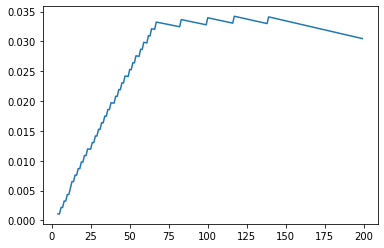

In [48]:
depths = np.linspace(500, 2000, 200)

max_eff = []
for depth in depths:
    temp = calc_temp(depth)
    invalids = calc_constraints(temp)
    efficiency = calc_efficiency(depth)
    efficiency[invalids] = None
    
    max_eff.append(np.nanmax(efficiency))
    
#     plt.figure()
#     plt.title("Efficiency at " + str(temp) + "(K) and " + str(depth) + "(m)")
#     plt.contourf(p1_mesh, p2_mesh, efficiency)
#     plt.colorbar()
#     plt.show()

# print(max_eff)
plt.plot(max_eff)
plt.show()

In [4]:
h1_grid = state1.h.reshape(num_p1, num_p2)
h2_grid = state2.h.reshape(num_p1, num_p2)

m_dot_grid = W_turb / (h2_grid - h1_grid)

# filter out invalid and infinite m_dots
m_dot_grid[invalid] = None
m_dot_grid[np.isinf(m_dot_grid)] = None


fig = plt.figure()
plt.contourf(p1_mesh, p2_mesh, m_dot_grid)
plt.title('Mass Flow Rate Required for 125kW turbine power')
plt.xlabel('Operating pressure of Evaporator (Pa)')
plt.ylabel('Operating pressure of Condenser (Pa)')
plt.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
plt.colorbar(label='Mass Flow Rate (kg/s)')
fig.set_size_inches(8, 6)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


### Calculate $W_\text{turbine} / W_\text{pump}$

In [5]:
h3_grid = state3.h.reshape(num_p1, num_p2)
h4_grid = state4.h.reshape(num_p1, num_p2)

# Calculates the ratio of W_turb/W_work
W_ratio = (h2_grid - h1_grid) / (h4_grid - h3_grid)
W_ratio[invalid] = None

fig = plt.figure()
plt.contourf(p1_mesh, p2_mesh, W_ratio)
plt.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
plt.title('Ratio of Turbine Work to Pump Work')
plt.xlabel('Operating pressure of Evaporator (Pa)')
plt.ylabel('Operating pressure of Condenser (Pa)')
plt.colorbar(label='W_in / W_out')
fig.set_size_inches(8, 6)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


### Calculate work by pump

In [6]:
h3_grid = state3.h.reshape(num_p1, num_p2)
h4_grid = state4.h.reshape(num_p1, num_p2)

W_pump = m_dot_grid * (h4_grid - h3_grid)
invalid = (p2_mesh / p1_mesh) > 1
W_pump[invalid] = None

W_net = W_turb + W_pump

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_size_inches(15, 5)

cf_pump = ax1.contourf(p1_mesh, p2_mesh, W_pump)
ax1.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
ax1.set_title('Pump Power')
ax1.set_xlabel('Operating pressure of Evaporator (Pa)')
ax1.set_ylabel('Operating pressure of Condenser (Pa)')
ax1.scatter(9.57e5, 6.25e5, color='k')
fig.colorbar(cf_pump, ax=ax1, label='W_pump (W)')

cf_ratio = ax2.contourf(p1_mesh, p2_mesh, W_net)
ax2.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
ax2.set_title('Net Work')
ax2.set_xlabel('Operating pressure of Evaporator (Pa)')
ax2.set_ylabel('Operating pressure of Condenser (Pa)')
fig.colorbar(cf_ratio, ax=ax2, label='W_net (W)')

### Thermal Efficiency

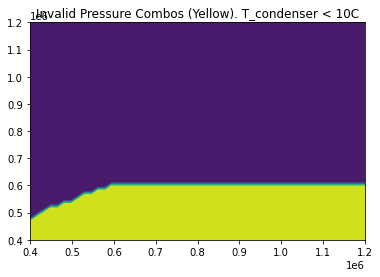

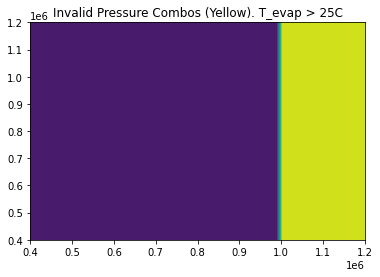

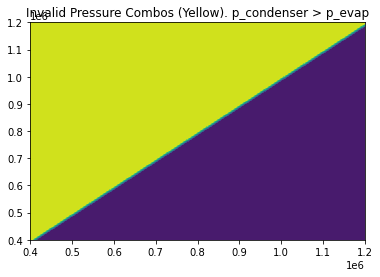

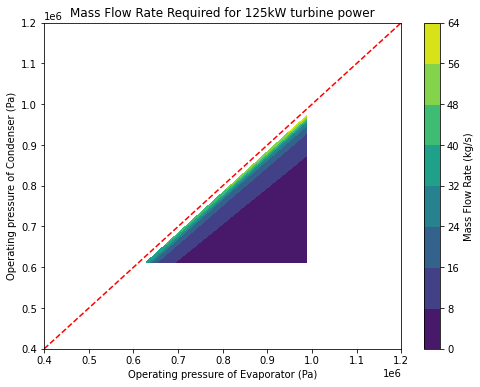

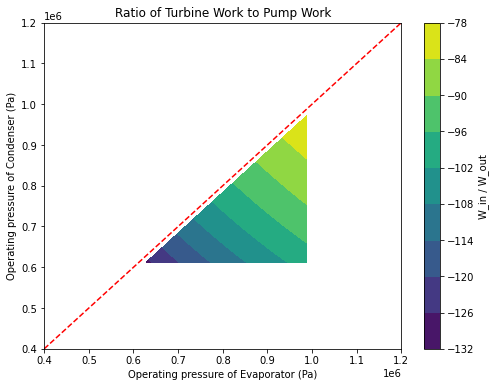

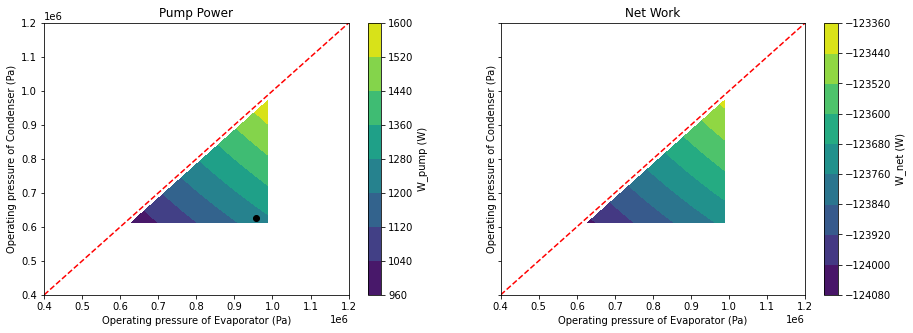

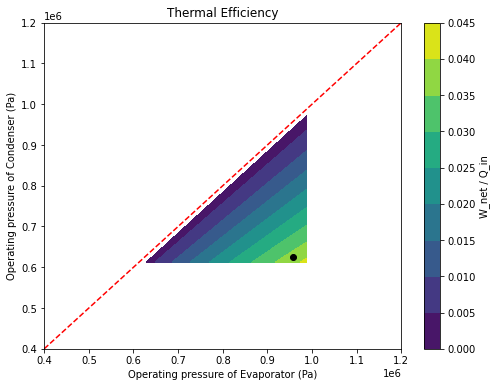

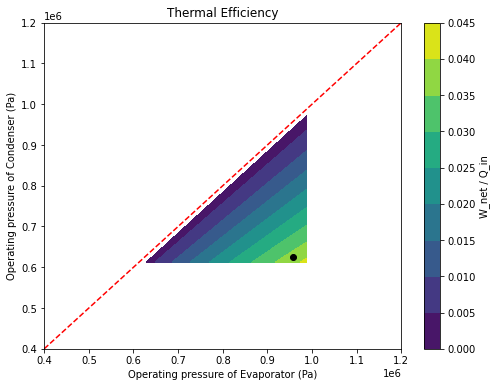

In [8]:
h1_grid = state1.h.reshape(num_p1, num_p2)
h4_grid = state4.h.reshape(num_p1, num_p2)

Q_in = -(h1_grid - h4_grid) * m_dot_grid
Q_in[invalid] = None


fig = plt.figure()
plt.contourf(p1_mesh, p2_mesh, (W_net + 17e3)/Q_in)
plt.plot([min(p1s), max(p2s)], [min(p1s), max(p2s)], 'r--')
plt.title('Thermal Efficiency')
plt.xlabel('Operating pressure of Evaporator (Pa)')
plt.ylabel('Operating pressure of Condenser (Pa)')

plt.colorbar(label='W_net / Q_in')
plt.scatter(9.57e5, 6.25e5, color='k')
fig.set_size_inches(8, 6)
plt.show()

### Calculate Work needed from pumps

In [21]:
def calc_darcy_friction(Re, roughness, diameter):
    # approximate darcy friction factor from Swamee and Jain
    # https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae#Table_of_Approximations
    
    assert Re > 5000, "Reynolds number too low for this approximation"
    rr = roughness / diameter
    f = 0.25 / (np.log10(rr/3.7 + 5.74/Re**0.9))**2
    return f

def calc_pipe_loss(m_dot, roughness, diameter, length, rho=1030, mu=0.00161, eta_mech = 0.75, eta_entropy = 0.8):
    vel = m_dot / (np.pi * (diameter / 2)**2) / rho
    Re = rho * vel * diameter / mu
    ff = calc_darcy_friction(Re, roughness, diameter)
    dP = ff * rho * length * vel**2 / 2 / diameter
    power = dP * m_dot / rho / eta_mech / eta_entropy
    return power


m_dot_hot = 900
m_dot_cold = 450

roughness_cold = 0.0053
roughness_hot = 0.003

diameter_cold = 0.72
diameter_hot = 0.8

l_cold = 1000
l_hot = 50

p_hot = calc_pipe_loss(m_dot_hot, roughness_hot, diameter_hot, l_hot, mu=0.00097)
p_cold = calc_pipe_loss(m_dot_cold, roughness_cold, diameter_cold, l_cold)

print((p_hot + p_cold)/125e3)

plt.contourf(p1_mesh, p2_mesh, W_net + (p_hot + p_cold))
plt.colorbar()

0.19725897753667518


NameError: name 'W_net' is not defined

### Calculate ocean temp vs. depth
<img src="https://upload.wikimedia.org/wikipedia/commons/c/cb/THERMOCLINE.png" alt="Drawing" style="width: 500px;"/>


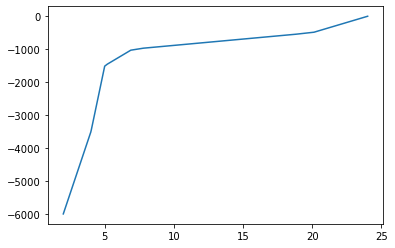

In [29]:
depths = [0, 500, 1000, 1500, 3500, 6000]
temps = [24, 20, 7, 5, 4, 2]

def calc_temp(depth):
    return np.interp(depth, depths, temps)

ds = np.linspace(0, 6000, 100)
ts = calc_temp(ds)
plt.plot(ts, -ds)